# CUSUM Filter
Cumulative sum https://en.wikipedia.org/wiki/CUSUM

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [64]:
df = pd.read_csv("../data/testing.csv")
len(df)

44184

In [76]:
df["time"] = list(map(lambda x: datetime.datetime.fromtimestamp(x/1000), df.time))

In [77]:
df1 = df.set_index(["time"], drop=True)

In [78]:
df2 = df1[["close"]]

In [101]:
def get_daily_vol(close, span0=100):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
#     print(len(close.loc[df0.index]))
#     print(close.loc[df0.index])
#     return close.loc[df0.values].values

#     df0=close.loc[df0.index].close/close.loc[df0.values].values-1 # daily returns
    index = close.loc[df0.values].index
    print(len(df0))
    print(len(close.loc[df0.index].close))
    print(len(close.loc[df0.values].values))
#     return (close.loc[df0.values])

    df0 = pd.Series(list(map(lambda x, y: x/y-1, close.loc[df0.index].close, close.loc[df0.values].values)))
#     df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    print(len(df0))
    df0=df0.ewm(span=span0).std()
    dfd = {"time":index, "vol":df0}
    df1 = pd.DataFrame(dfd).set_index(["time"], drop=True)
    return df1

In [102]:
a = get_daily_vol(df2)
a

37457
42165
37757
37757


,vol
time,
2020-04-23 07:11:20.118,NaN
2020-04-23 07:11:47.983,0.000173
2020-04-23 07:12:09.556,0.000403
2020-04-23 07:12:16.241,0.000333
2020-04-23 07:12:16.241,0.000295
...,...
2020-04-29 01:45:32.184,0.002268
2020-04-29 01:46:07.532,0.002279
2020-04-29 01:46:41.273,0.002296


In [116]:
df

,time,open,high,low,close,volume
0,2020-04-23 07:10:55.172,7360.10,7360.71,7360.00,7360.70,15.230057
1,2020-04-23 07:10:56.888,7360.71,7361.70,7360.00,7361.27,15.077027
2,2020-04-23 07:10:58.848,7361.69,7362.46,7359.00,7359.00,13.923700
3,2020-04-23 07:11:02.499,7358.77,7360.99,7358.23,7358.59,13.609477
4,2020-04-23 07:11:05.706,7358.58,7359.70,7355.00,7355.13,13.674025
...,...,...,...,...,...,...
44179,2020-04-30 01:46:07.325,9172.23,9174.88,9170.00,9174.82,11.073791
44180,2020-04-30 01:46:23.212,9174.84,9175.48,9173.61,9174.27,10.962070
44181,2020-04-30 01:46:49.805,9174.26,9174.26,9170.50,9174.00,11.585002
44182,2020-04-30 01:47:27.128,9174.01,9174.01,9172.00,9172.93,11.011935


In [65]:
def get_t_events(g_raw, h):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold (possibly float or int)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    t_events, s_pos, s_neg = [], 0, 0
    diff = g_raw.diff()
    for i in diff.index[1:]:
        s_pos, s_neg = max(0, s_pos+diff.loc[i]), min(0, s_neg+diff.loc[i])
        if s_neg<-h:
            s_neg = 0
            t_events.append(i)
        elif s_pos>h:
            s_pos = 0
            t_events.append(i)
        else:
            t_events.append(None)
    return t_events

In [66]:
a = get_t_events(df.close, 200)
a = [None] + a

In [71]:
b = list(map(lambda x, c: c if x != None else None, a, df.close))

In [72]:
len(a)

44184

In [73]:
len(df.close)

44184

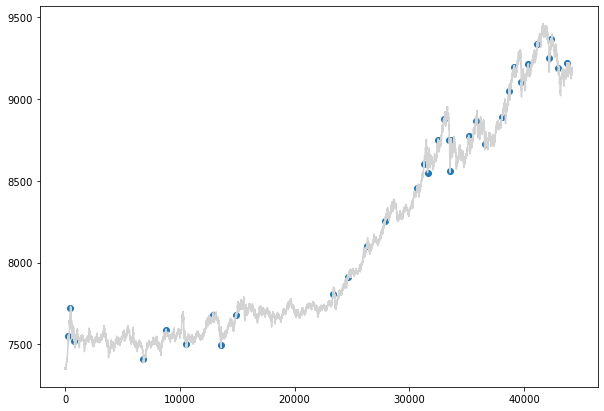

In [74]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(range(len(a)), b)

ax.plot(df.close, color="lightgrey")


In [112]:
np.std(df.close[35000:40000])

172.78365605699832